In [4]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from random import choices
from trial_1 import Building

# define class for building
# class Building:
#     def __init__(self, id, geometry, center_point, bld_type):
#         self.id = id
#         self.geometry = geometry
#         self.center_point = center_point
#         self.bld_type = bld_type

# importing osm location
address = "Çimentepe Mahallesi"
buildings = ox.features.features_from_address(address, tags={'building': True}, dist=350)

# creating object for each building
bld_lst = []
for i in buildings.index:
    id = i[1]
    geo = buildings.loc[i, 'geometry']
    center_point = geo.centroid
    bld_function = buildings.loc[i, 'building']

    bld = Building(id, geo, center_point, bld_function)
    bld_lst.append(bld)

[0, [<trial_1.Building object at 0x000001F975152D90>, <trial_1.Building object at 0x000001F975152550>, <trial_1.Building object at 0x000001F975152100>]]
[1, [<trial_1.Building object at 0x000001F96BFDB250>]]
[2, [<trial_1.Building object at 0x000001F9751521C0>, <trial_1.Building object at 0x000001F974BE2BE0>]]
[3, [<trial_1.Building object at 0x000001F974EC9B20>, <trial_1.Building object at 0x000001F974EC9AF0>, <trial_1.Building object at 0x000001F974EC9AC0>, <trial_1.Building object at 0x000001F974EC9A90>, <trial_1.Building object at 0x000001F974BF6A90>, <trial_1.Building object at 0x000001F974EC9A60>]]
[4, [<trial_1.Building object at 0x000001F974BF6A00>, <trial_1.Building object at 0x000001F9751524C0>, <trial_1.Building object at 0x000001F974BE27C0>, <trial_1.Building object at 0x000001F974BF6AF0>, <trial_1.Building object at 0x000001F975152790>, <trial_1.Building object at 0x000001F974BF6B20>, <trial_1.Building object at 0x000001F974BF6B50>, <trial_1.Building object at 0x000001F974

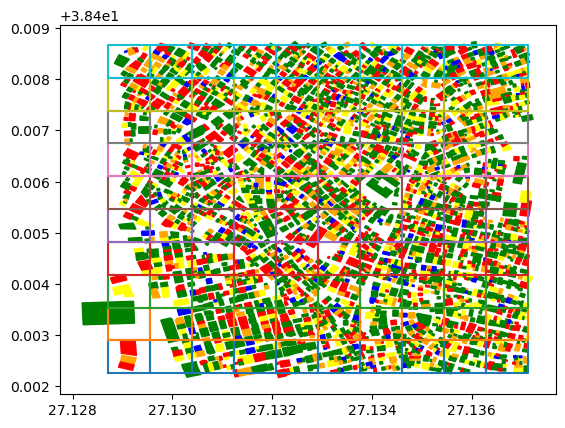

In [5]:
import numpy as np
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_polygon
from trial_1 import Sub_Area

center_points = gpd.GeoDataFrame({'points': [o.center_point for o in bld_lst]}, geometry = 'points')

# set bounds of graph to the bounds of center points
xmin, ymin, xmax, ymax = center_points.total_bounds
x_range = xmax - xmin
y_range = ymax - ymin

# set stepsize
width = x_range / 10
height = y_range / 10

# create cols and rows based on bounds and stepsize
cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax + height, height))

# create empty graph
fig, ax = plt.subplots()

# sort the list of buildings objects based on x coordinates, then y coordinates
sorted_blds = sorted(bld_lst, key=lambda x: (x.center_point.x, x.center_point.y))

# create cells and plot to graph, add buildings to subarea classes
sub_areas = []
i = 0
j = 0
for x in cols[:-1]:
    # while the buildings have x values in the range of this column, add them to a list
    filt_blds = []
    while (sorted_blds[i].center_point.x >= x) and (sorted_blds[i].center_point.x < (x+width)): 
        filt_blds.append(sorted_blds[i])
        filt_blds = sorted(filt_blds, key=lambda x: (x.center_point.y))
        i += 1
    for y in rows[:-1]:
        # create a cell, sub_area object, and associate the cell with the object
        polygon = Polygon([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])
        sub_area = Sub_Area(j)
        j += 1
        ax.plot(*polygon.exterior.xy)
        sub_area_blds = []
        # while the buildings in that column have y values in the range of this row, add them to the cell object 
        while (len(filt_blds) > 0) and (filt_blds[0].center_point.y >= y) and (filt_blds[0].center_point.y < (y+height)):
            sub_area.add_building(filt_blds.pop(0))
        sub_areas.append(sub_area)

for o in sub_areas:
    print([o.sub_area_id, o.buildings])


# this is plotting the geometry of the buildings
# save each geometry attribute in a list
geos = [o.geometry for o in bld_lst]

# choices of different colours with corresponding weights
population = ['green', 'blue', 'yellow', 'orange', 'red']
weights = [0.45, 0.05, 0.15, 0.12, 0.23]

# for every geometry choose a colour, fill the geometry and plot to graph
for g in geos:
    c = choices(population, weights)[0]
    x, y = g.exterior.xy
    ax.fill(x, y, color = c)

# Display the plot
plt.show()

In [28]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsPoint("Footprints", "F", "List of footprints imported")]
)

def import_footprints():
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
    polygon = rs.Curve.CreateControlPointCurve(c_pts)
    return hs.HopsCurve(polygon)

if __name__ == "__main__":
    app.run()


 * Serving Flask app "__main__" (lazy loading)


 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


[INFO]  * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "GET /imft HTTP/1.1" 200 -
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "GET /imft HTTP/1.1" 200 -
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ddd0a31040>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1ddd0a317c0>
[INFO] Solving using legacy API: <HopsComponent /imft [ -> ImportFootprints -> Footprints] >
[INFO] 127.0.0.1 - - [12/Oct/2023 14:08:47] "POST /solve HTTP/1.1" 200 -
